<a class="anchor" id="top"></a>
# Contents
*Start from the beginning, or click to jump to a particular section*

1. [Introduction](#intro)
2. [Importing Datasets and Libraries](#imports)
3. [Data Exploration and Cleaning](#cleaning) <br>
4. [Analysis](#analysis) <br>
    4.1 [General Medal Counts](#medals) <br>
    4.2 [USA Performance](#countries) <br>
    4.3 [Athlete Specific Medals](#athlete_medals) <br>
    4.4 [Athlete Demographics](#athletes)


<a class="anchor" id="intro"></a>
## 1. Introduction

Welcome!

This notebook is an exploration of Olympic events/athletes from the past 100+ years. It is going to be using predominatly the pandas Python library for manipulating the datasets and the matplotlib Python library for creating some visualizations. It's entirely for fun, and a way for me to play around/practice some Python skills on a larger dataset.

As for the dataset, it is sources from the "120 Years of Olympic History: Athletes and Results" dataset from RGriffin linked [here](https://www.kaggle.com/datasets/heesoo37/120-years-of-olympic-history-athletes-and-results). It consits of historical data from each Olympic Games from Athens 1896 to Rio 2016, scraped by RGriffin from www.sports-reference.com. .

There are two datasets that I'm  working with here: 

1. The *athlete_events.csv* file has 134732 rows and 15 columns, which are as follows:
* **ID** - Unique number for each athlete
* **Name** - Athlete's name
* **Sex** - M or F
* **Age** - Integer
* **Height** - In centimeters
* **Weight** - In kilograms
* **Team** - Team name. NOTE: Not the same as Country
* **NOC** - National Olympic Committee 3-letter code
* **Games** - Year and season
* **Year** - Integer
* **Season**- Summer or Winter
* **City** - Host city
* **Sport** - Sport
* **Event** - Event
* **Medal** - Gold, Silver, Bronze, or NA

2. The *NOC_regions.csv* file has the Country name corresponding to the three letter National Olympic Committee (NOC) Code:
* **NOC** - 3-letter National Olympic Committee code
* **Country** - Name of country
* **Notes** - Some helpful notes

[Go to Top](#top)
<a class="anchor" id="imports"></a>
## 2. Importing Datsets and Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import datetime as dt

Import the **events** dataset, which is a list of olympic events from both Summer and Winter Olympics from Athens 1896 to Rio 2016.

Importing the **countries** dataset, which is a list of the 'NOC' designation and the full country name. We'll join this to the main events dataset.

In [2]:
events = pd.read_csv('athlete_events.csv')
countries = pd.read_csv('noc_regions.csv')

<a class="anchor" id="joining"></a>
### Joining Countries to the Events Dataset

For easier readability, I don't want to use the NOC code, and instead want to join the **events** and **countries** datsets together using a left join so I can use the Country name for the rest of the analysis.

The merged result will be **df**, which will be the basis of all the future charts/tables in this notebook. Here is a preview:

In [3]:
df = events.merge(countries, how = 'left', on = 'NOC')
df.rename(columns = {'region': 'Country',
                    'Name': 'Athlete Name',
                    'notes': 'Notes'}, 
          inplace = True)
df.head()

,ID,Athlete Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country,Notes
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,Denmark,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,Netherlands,NaN


[Go to Top](#top)
<a class="anchor" id="cleaning"></a>
## 2. Data Exploration and Cleaning

In this section, I want to get to know the datset a little better. I want to find if there are any anomolies that would impact my analysis moving forward, as well as restructuring the data to fit my needs little better.

At the top, I want to take a look at each column to see if there are any efficiency changes I can do at the top to make the analysis a little faster. I'll do this either by dropping unwanted columns or changing the datatypes to something less memory-intensive. I also want to check for null values. 

The *.info()* method is a powehouse for the cleaning portion, as it gives me the dateset size, columns, null counts, datatypes, and total memory usage for the **df** dataframe.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271116 entries, 0 to 271115
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            271116 non-null  int64  
 1   Athlete Name  271116 non-null  object 
 2   Sex           271116 non-null  object 
 3   Age           261642 non-null  float64
 4   Height        210945 non-null  float64
 5   Weight        208241 non-null  float64
 6   Team          271116 non-null  object 
 7   NOC           271116 non-null  object 
 8   Games         271116 non-null  object 
 9   Year          271116 non-null  int64  
 10  Season        271116 non-null  object 
 11  City          271116 non-null  object 
 12  Sport         271116 non-null  object 
 13  Event         271116 non-null  object 
 14  Medal         39783 non-null   object 
 15  Country       270746 non-null  object 
 16  Notes         5039 non-null    object 
dtypes: float64(3), int64(2), object(12)
memory usage

### Column Alterations

Firstly, I won't be using the ID or Notes columns so I'll drop those.

Next, any athlete who did not win a medal has a null value in the 'Medal' column. I change there to the word 'None' to make medla counts a little simpler and to let me change the 'Medal' column to a category (can't have null values).

Lastly, I changed any columns with a relatively small number of possibilities to categories (i.e. Sex, Season, Games, Sport, City, and Medal). This will make all the grouping and pivotingl ater on run faster.

In [5]:
# Drop ID and Notes columns
df.drop('ID', axis = 'columns', inplace = True)
df.drop('Notes', axis = 'columns', inplace = True)

# Replacing any N/A in 'Medals' with 'None'
df['Medal'].fillna('None', inplace = True) 

# Change 6 columns to category
df['Sex'] = df['Sex'].astype('category')
df['Season'] = df['Season'].astype('category')
df['Games'] = df['Games'].astype('category')
df['Sport'] = df['Sport'].astype('category')
df['City'] = df['City'].astype('category')
df['Medal'] = df['Medal'].astype('category')

### Null values

From the initial *info()* summary table (before column alterations), there were 6 columns that had less than 271116 non-null values. Up to this point, I've already addressed 2 of them:

* *Medal*: replaced nulls with 'None'
* *Notes*: dropped the column entirely
* *Country*
* *Age*
* *Height*
* *Weight*

Next, I'll look at 'Country'

One of the first things I noticed when peviewing the datset is that the 'Team' column and the 'Country' column look fairly similar. However, if I look at the number of unique values for each column (and I would expect that to be reasonably close to the number of countries in the world), I find that 'Team' actually has 1184 unique values while 'Country' has 205. Red flag!

In [6]:
# Unique Team values
df['Team'].nunique()

1184

In [7]:
# Unique Country values
df['Country'].nunique()

205

In fact, when looking for any Team name that contains the phrase 'United States', there are actually 22 unique results spanning 5 different 'Country' codes. So for any of our country-analysis, we will use 'Country' instead of Team. (Although I don't want to drop 'Team' entirely because it might be interesting on a smaller scale)

In [8]:
# All the different ways 'United States' shows up in the 'Team' column
df[df['Team'].str.contains('United States')]['Team'].unique()

array(['United States', 'United States Virgin Islands', 'United States-1',
       'United States-2', 'United States-3', 'United States-10',
       'United States Virgin Islands-2', 'United States Virgin Islands-1',
       'United States Golf Association-3', 'United States-9',
       'United States-6', 'United States-7', 'United States/France',
       'United States/Great Britain', 'United States-14',
       'United States-4', 'Germany/United States', 'United States-5',
       'United States-8', 'United States-12', 'United States-11',
       'United States-13'], dtype=object)

Before I can use the 'Country' column efficiently, I have to address the 370 null values. I find that the 370 null values are split between only 4 NOC codes: SGP, ROT, TUV, and UNK.

In [9]:
df[df['Country'].isnull()]['NOC'].value_counts()

SGP    349
ROT     12
TUV      7
UNK      2
Name: NOC, dtype: int64

A quick internet search and I know that they are:
* SGP: Singapore
* ROT: Refugee Olympic Team
* TUV: Tuvalu
* UNK: Unknown

I replaced the first three country names in **df** and deleted the athletes from an Unknown Country

In [10]:
singapore = df['NOC'] == 'SGP'
df.loc[singapore, 'Country'] = 'Singapore'

refugee = df['NOC'] == 'ROT'
df.loc[refugee, 'Country'] = 'Refugee Olympic Team'

tuvalu = df['NOC'] == 'TUV'
df.loc[tuvalu, 'Country'] = 'Tuvalu'

# Drop Unknown athlete rows
df[df['NOC'] == 'UNK']
df.drop([61080, 130721], inplace = True)

The last 3 columns with null values are Height, Weight, and Age. This isn't that suprising given that a lot of these entries are from over 100 years ago, and there just may not be height/weight measurements for all 200,000+ event records.

I am alright with leaving these null values as is because I don't want to delete the rows and alter any other analytic metrics (e.g. athlete particpation, medal counts, etc). I also don't want to replace them with average value since there is likely ot be a lot of variation in these demographic values depending on the athlete's sport (more on this later!) and replacing these null values would dilute that uniqueness. The 200,000+ values that I do have here should be enough to pull some interesting insights from!

Looking at the end result, I've cut the memory usage down by ~35% and have no unexpected null values that could create any unwanted bugs. 

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271114 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   Athlete Name  271114 non-null  object  
 1   Sex           271114 non-null  category
 2   Age           261642 non-null  float64 
 3   Height        210945 non-null  float64 
 4   Weight        208241 non-null  float64 
 5   Team          271114 non-null  object  
 6   NOC           271114 non-null  object  
 7   Games         271114 non-null  category
 8   Year          271114 non-null  int64   
 9   Season        271114 non-null  category
 10  City          271114 non-null  category
 11  Sport         271114 non-null  category
 12  Event         271114 non-null  object  
 13  Medal         271114 non-null  category
 14  Country       271114 non-null  object  
dtypes: category(6), float64(3), int64(1), object(5)
memory usage: 22.2+ MB


### Exploring Duplicates

Something important to note about this data set is that it is a record of **individual athlete events**. Since each row still has a 'Medal' result, this results in a lot of duplicate medal counts when it comes to any sort of team sport where multiple athletes win the same medal in the same games. If I was trying to create a medal count table like the ones you'd see on TV or on Wikipedia, I would need to look at duplicate entries where the Games, Medal, And Event all matched and work around those (not necessarily drop since that would alter other metrics). 

Just doing a quick filter, I found that there are approximaely 26,000 rows that meet this criteria. Since this analysis is for fun/for free, I'm not going to dig into those here, therefore some numbers will differ from the official olympic statistics. Pleae use official Olympic sources if you need accuracy!

In [12]:
medalists = df[df['Medal'] != 'None'].sort_values(['Games','Country', 'Event'])
len(medalists[medalists.duplicated(['Games', 'Event', 'Medal'], keep = False)])

26704

[Go to Top](#top)
<a class="anchor" id="analysis"></a>
# 3. Analysis

On a technical level, my goal for this notebook is to play around with categorizing and grouping in pandas and translating that to a visual medium using matplotlib. I eventually want to use these plots as a framework to make a Tableau Dashboard where I can really finetune the visuals and make them interactive.

On an analytical level, I can break down this section into 4 main subsections:
* [General Games Stats](#medals)
* [United States Performance](#countries)
* [Athlete Specific Medals](#athlete_medals)
* [Athlete Demographics](#athletes)


[Go to Top](#top)
<a class="anchor" id="medals"></a>
## General Games Stats

Quick reminder of what the **df** dataframe looks like.

In [23]:
df.head(3)

,Athlete Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country
0,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,None,China
1,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,None,China
2,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,None,Denmark


I always thought of the Olympics as a constant (barring a global pandemic, that is) bi-annual occurence, alternating between Winter and Summer every 2 years. In fact, that tradition didn't start until the 1990's, prior to which, both the games were held concurrently every 4 years. 

Here we can see this shift in the overall timeline (as well as some conspicous gaps during both World Wars). THere is also a trend in general events increading over time (with 1980 as a noteable exception). 

It is also very clear that the Summer Games are much bigger and have significantly more events than the Winter Games (this makes sense when you consider the barrier to entry for a lot of winter sports (how many people have a ski-slope down the rode to play around on?), and how globablly ubiquitous the tentpole summer events like track or swimming are.

In [24]:
# Counts for events by season
summer_games = df[df['Season'] == 'Summer'].sort_values('Year').groupby(by = 'Year', observed = True).size()
winter_games = df[df['Season'] == 'Winter'].sort_values('Year').groupby(by = 'Year', observed = True).size()

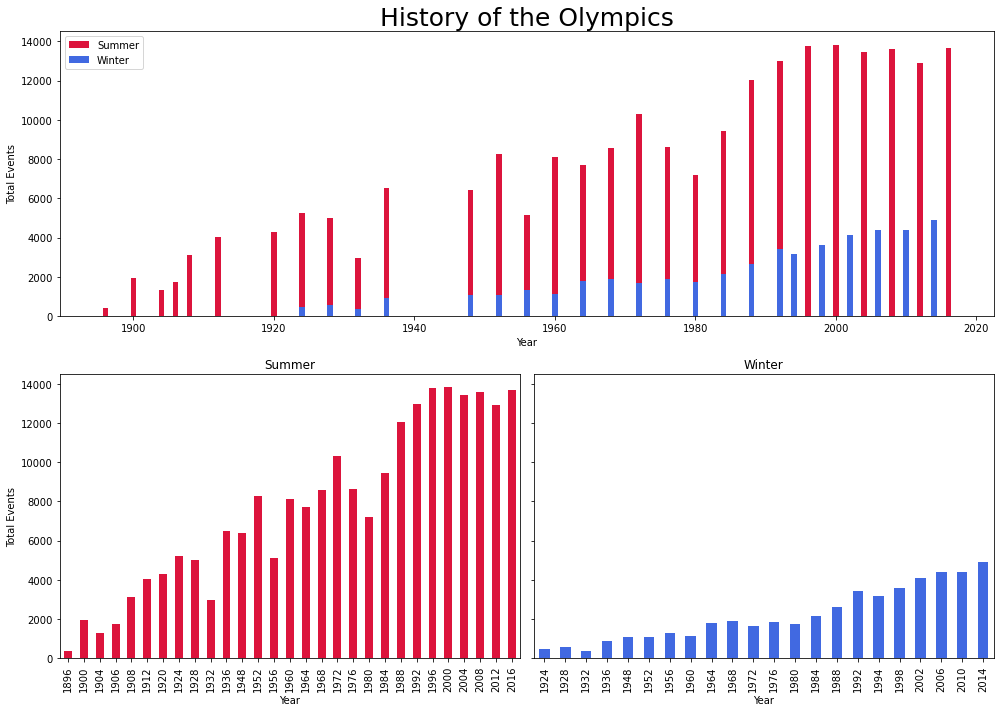

In [25]:
plt.figure(figsize = (14, 10))
gs = GridSpec(nrows=2, ncols=2)


plt.subplot(gs[0, :])           
plt.bar(summer_games.index, summer_games, color = 'crimson', label = 'Summer')
plt.bar(winter_games.index, winter_games, color = 'royalblue', label = 'Winter')
plt.title('History of the Olympics', fontsize = 25)
plt.ylabel('Total Events')
plt.xlabel('Year')
plt.legend()

# Summer Events
ax = plt.subplot(gs[1,0])
summer_games.plot(kind = 'bar', color = 'crimson')
plt.title('Summer')
plt.ylabel('Total Events')

# Winter Events
plt.subplot(gs[1,1], sharey = ax)
winter_games.plot(kind = 'bar', color = 'royalblue')
plt.title('Winter')

plt.tight_layout()

I was also curious if the number of individual athletes had a similar trend to events, since its possible one season has athletes that tend to compete in more events and create a disproportinate number of event records per capita.

However, athletes and events appear to correlate almost exactly. There are far more summer athletes than winter, and there are still the big dips in Summer participation in 1932, 1956, and 1980,

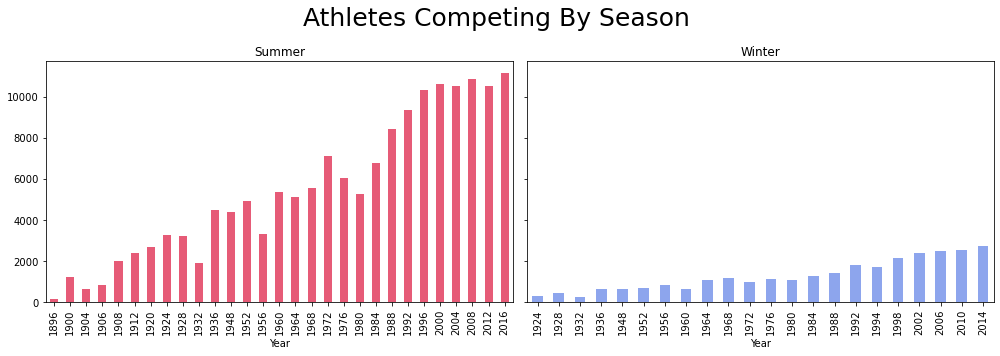

In [26]:
unique_athletes = df.drop_duplicates(subset = ['Athlete Name', 'Games'])
summer_athletes = unique_athletes[unique_athletes['Season'] == 'Summer'].sort_values('Year').groupby(by = 'Year', observed = True).size()
winter_athletes = unique_athletes[unique_athletes['Season'] == 'Winter'].sort_values('Year').groupby(by = 'Year', observed = True).size()


plt.figure(figsize = (14,5))
plt.suptitle('Athletes Competing By Season ', fontsize = 25)

# Summer Athletes
ax2 = plt.subplot(1,2,1)
summer_athletes.plot(kind = 'bar', color = '#e65b77')
plt.title('Summer')

#Winter Athletes
plt.subplot(1,2,2, sharey = ax2)
winter_athletes.plot(kind = 'bar', color = '#8da5ed')
plt.title('Winter')

plt.tight_layout()

I've already seen how the althletes/events have trended upward in recent years, but I also want to see if the individual sports played each year have smilarly changed. 

I was actually surprised that even though the Summer games did have a sharp increase from 19 to 34 from 1960 to 2000, the number of sports has remained overall steady since 2000. This trend also follows (though at a smaller scale) in the winter games, with an increase from 10 to 15 from 1988 to 2002, and then leveling out at 15 after 2002.

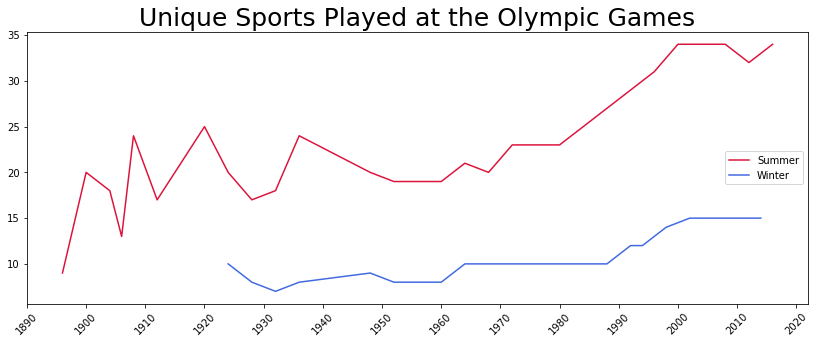

In [27]:
# Number of unique sports played each year 
number_of_sports_by_games_summer = df[df['Season'] == 'Summer'].drop_duplicates(subset = ['Games', 'Sport']).groupby('Year', observed = True).agg({'Sport': 'size'})
number_of_sports_by_games_winter = df[df['Season'] == 'Winter'].drop_duplicates(subset = ['Games', 'Sport']).groupby('Year', observed = True).agg({'Sport': 'size'})

# merge summer and winter together so they share the same x-axis/index
sports_per_games = number_of_sports_by_games_summer.merge(number_of_sports_by_games_winter, 
                                       how = 'outer', 
                                       on = 'Year', 
                                       suffixes = ['Summer', 'Winter']).sort_index()
# axis values
y_summer = sports_per_games['SportSummer'].dropna()
y_winter = sports_per_games['SportWinter'].dropna()
x_summer = y_summer.index
x_winter = y_winter.index

# plot
plt.figure(figsize = (14,5))
plt.plot(x_summer, y_summer, color = 'crimson', label = 'Summer')
plt.plot(x_winter, y_winter, color = 'royalblue', label = 'Winter')
plt.title('Unique Sports Played at the Olympic Games', fontsize = 25)
plt.legend(loc = 'center right')
plt.xticks(np.arange(1890,2030,10), rotation = 45)
plt.show()

When I think of Olympic stats, the first thing that comes to mind is a medal count table similar to the one found in [this wikipedia page](https://en.wikipedia.org/wiki/All-time_Olympic_Games_medal_table). To create a similar table, I added together the total number of times Gold, Silver, and Bronze appeared in the 'Medal' column for each country in each season, and then got a total medal count for those medals.

Finally, I merged them together to give one table and sorted to show the highest medal winning countries at the top. We find the United States at the top, followed by Russia, Germany, UK, and France.

*Worth noting that by the nature of sorting on Country and not Team, Russia has the combined medals of Russia and the Soviet Union* 

In [28]:
# Group df by the 3 columns we care about: Country, Medal, and Season
season_medal_count = df.groupby(['Country', 'Medal', 'Season']).size().unstack().unstack()

# Create winter medal chart
winter_medal_count = season_medal_count['Winter'].copy()
winter_medal_count.drop('None', axis = 'columns', inplace = True)
total_w = winter_medal_count.sum(axis = 1)
winter_medal_count.insert(3, column = 'Total', value = total_w)
winter_medal_count.sort_values('Total', ascending = False, inplace = True)
winter_medal_count = winter_medal_count[['Gold', 'Silver', 'Bronze', 'Total']]

# Create summer medal chart
summer_medal_count = season_medal_count['Summer'].copy()
summer_medal_count.drop('None', axis = 'columns', inplace = True)
total_s = summer_medal_count.sum(axis = 1)
summer_medal_count.insert(3, column = 'Total', value = total_s)
summer_medal_count.sort_values('Total', ascending = False, inplace = True)
summer_medal_count = summer_medal_count[['Gold', 'Silver', 'Bronze', 'Total']]

# Create overall country medal count
country_medal_count = df.groupby(['Country', 'Medal']).size().unstack()
country_medal_count.drop('None', axis = 'columns', inplace = True)
total_m = country_medal_count.sum(axis = 1)
country_medal_count.insert(3, column = 'Total', value = total_m)
country_medal_count.sort_values('Total', ascending = False, inplace = True)
country_medal_count = country_medal_count[['Gold', 'Silver', 'Bronze', 'Total']]

# Put it all together to get our total medal table
all_medals = pd.merge(pd.merge(summer_medal_count, winter_medal_count, on = 'Country', suffixes = ('- s', '- w')), country_medal_count, on = 'Country')
all_medals.head(15)

Medal,Gold- s,Silver- s,Bronze- s,Total- s,Gold- w,Silver- w,Bronze- w,Total- w,Gold,Silver,Bronze,Total
Country,,,,,,,,,,,,
USA,2472,1333,1197,5002,166,308,161,635,2638,1641,1358,5637
Russia,1220,974,994,3188,379,196,184,759,1599,1170,1178,3947
Germany,1075,987,1064,3126,226,208,196,630,1301,1195,1260,3756
UK,636,729,620,1985,42,10,31,83,678,739,651,2068
France,465,575,587,1627,36,35,79,150,501,610,666,1777
Italy,518,474,454,1446,57,57,77,191,575,531,531,1637
Australia,362,456,515,1333,6,3,7,16,368,459,522,1349
Hungary,432,328,363,1123,0,4,8,12,432,332,371,1135
Sweden,354,396,358,1108,125,126,177,428,479,522,535,1536


Converting that chart into a plot, we can see the medal breakdown of the top 20 countries.

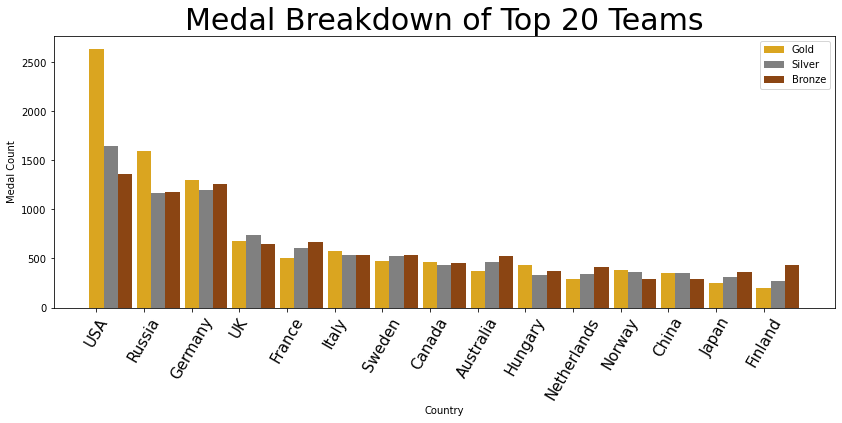

In [29]:
# Set axis values
x = country_medal_count[['Gold', 'Silver', 'Bronze']].head(15).index
y_gold = country_medal_count['Gold'].head(15).values
y_silver = country_medal_count['Silver'].head(15).values
y_bronze = country_medal_count['Bronze'].head(15).values

# Create figure and spacing for bars
plt.figure(figsize = (14, 5))
N = 15
ind = np.arange(N)
width = 0.3 

# Create 3 medal bars
plt.bar(ind, y_gold, width = width, label = 'Gold', color = 'goldenrod')
plt.bar(ind + width, y_silver, width = width, label = 'Silver', color = 'grey')
plt.bar(ind + 2*width, y_bronze, width = width, label = 'Bronze', color = 'saddlebrown')

plt.title('Medal Breakdown of Top 20 Teams', fontsize = 30)
plt.xticks(ticks = ind, labels = x, rotation = 60, fontsize = 15)
plt.xlabel('Country')
plt.ylabel('Medal Count')
plt.legend()
plt.show()

Next, I want to see if the top countries are at the top because their athletes are actually stronger in their respective sports, or if perhaps it's simply a numbers game and they just send a LOT of athletes to the games and the medals are just statistically more likely. 

For this, I divided the number of medals each country has won by the number of athletes they have competing to get a "Medal to Athlete Ratio" ('M/A Ratio').

The top three medal winners (US, Russia, and Germany) are also in the top 3 'M/A Ratio' with around 30% of athletes winning a medal. Surpringly, Pakistan ranks 4th with 22% of athletes winning a medal despite it not even being in the top 15 overall medal winners. The UK is ranked 13 in M/A Ratio, and France isnt even in the top 15.  

[Go to Top](#top)
<a class="anchor" id="countries"></a>
## United States Performance

Here, we'll be looking speciifically at how Team USA has performed in the olympic games. So we'll only be working with two main datasets:
* **us_athletes**: All athletes who had an event, regardless of if they medaled
* **us_medalists**: Any memeber of Team USA who received a medal

In [31]:
us_athletes = df[df['Country'] == 'USA']
us_medalists = us_athletes[us_athletes['Medal'] != 'None']

Here is the top 10 sports that Team USA has received a medal in

In [32]:
us_medalists.groupby('Sport').size().sort_values(ascending = False).head(10)

Sport
Athletics     1080
Swimming      1078
Rowing         375
Basketball     341
Ice Hockey     276
Gymnastics     194
Shooting       193
Water Polo     150
Sailing        140
Diving         140
dtype: int64

In [33]:
us_medal_count = us_medalists.groupby(['Sport', 'Medal']).size().unstack()
us_medal_count.drop('None', axis = 'columns', inplace = True)
totals = us_medal_count.sum(axis = 1)
us_medal_count.insert(3, column = 'Total', value = totals)
us_medal_count.sort_values('Total', ascending = False, inplace = True)
us_medal_count

Medal,Bronze,Gold,Silver,Total
Sport,,,,
Athletics,221,542,317,1080
Swimming,175,649,254,1078
Rowing,88,186,101,375
Basketball,36,281,24,341
Ice Hockey,31,56,189,276
...,...,...,...,...
Handball,0,0,0,0
Military Ski Patrol,0,0,0,0
Rugby Sevens,0,0,0,0


Olympic Games hosted in the United States
* 1904 Summer
* 1932 Winter/Summer
* 1960 Winter
* 1980 Winter
* 1984 Summer
* 1996 Summer
* 2002 Winter

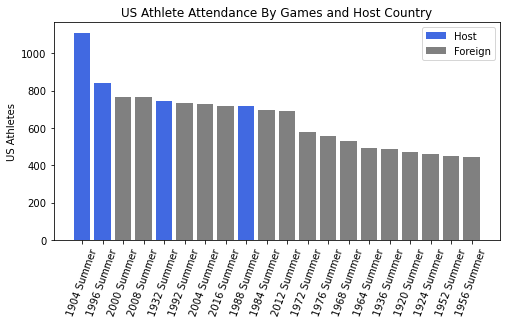

In [34]:
from matplotlib.patches import Patch
games_participation = us_athletes.groupby('Games').size().sort_values(ascending = False)
x = games_participation.head(20).index
y = games_participation.head(20).values
colors = ['royalblue','royalblue','grey','grey','royalblue','grey','grey','grey','royalblue','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey']

plt.figure(figsize = (8,4))
plt.bar(x,y, color = colors)
plt.title('US Athlete Attendance By Games and Host Country')
plt.xticks(rotation = 70, fontsize = 10)
plt.ylabel('US Athletes')
legend_elements = [Patch(facecolor='royalblue', label='Host'),
                  Patch(facecolor = 'grey', label = 'Foreign')]
plt.legend(handles=legend_elements)
plt.show()


[Go to Top](#top)
<a class="anchor" id="athlete_medals"></a>
## Athelete Specific Medals

The top 10 medal winners in history. The US swimmer Michael Phelps is the most decorated Olympian in history with 28 medals. And we see that swimming and gymnastics both offer enough opportunities for medals that they dominate the field.

In [35]:
any_medalists = df[df['Medal'] != 'None']
athlete_sport_pivot = any_medalists.pivot_table(values = 'Medal', index = ['Athlete Name', 'Sport'], aggfunc = 'count').sort_values('Medal', ascending = False)
athlete_sport_pivot.head(10)

,,Medal
Athlete Name,Sport,
"Michael Fred Phelps, II",Swimming,28
Larysa Semenivna Latynina (Diriy-),Gymnastics,18
Nikolay Yefimovich Andrianov,Gymnastics,15
Borys Anfiyanovych Shakhlin,Gymnastics,13
Ole Einar Bjrndalen,Biathlon,13
Edoardo Mangiarotti,Fencing,13
Takashi Ono,Gymnastics,13
"Dara Grace Torres (-Hoffman, -Minas)",Swimming,12
"Jennifer Elisabeth ""Jenny"" Thompson (-Cumpelik)",Swimming,12


We also can find the athlete who won the most medals at each Olympic Games. Here were are looking at the last 10 Games (not surprisingly, Michael Phelps has dominated every Summer Games since 2004.

The record for most medals in a single game in 8, with 3 occurences
* 2008: Michael Phelps (Swimming)
* 2004: Michael Phelps (Swimming)
* 1980: Aleksandr Dityatin (Gymnastics)*

*1980 Summer Olympics were held in Moscow, and 66 countries boycotted due to Cold War political tensions.

In [36]:
athlete_games_pivot = any_medalists.pivot_table(values = 'Medal', index = ['Athlete Name', 'Games'], aggfunc = 'count').sort_values('Medal', ascending = False)
athlete_games = athlete_games_pivot.reset_index()
athlete_games_group = athlete_games.groupby('Games')
df1 = pd.DataFrame(columns = athlete_games.columns)
for games, athletes in athlete_games_group:
    top_medal_winner = athletes.nlargest(1, 'Medal')
    df1 = df1.append(top_medal_winner)

C:\Users\tbert\AppData\Local\Temp\ipykernel_17628\359938369.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(top_medal_winner)
C:\Users\tbert\AppData\Local\Temp\ipykernel_17628\359938369.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(top_medal_winner)
C:\Users\tbert\AppData\Local\Temp\ipykernel_17628\359938369.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(top_medal_winner)
C:\Users\tbert\AppData\Local\Temp\ipykernel_17628\359938369.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(top_medal_winner)
C:\Users\tbert\AppData\Local\Temp\ipykernel_17628\359938

C:\Users\tbert\AppData\Local\Temp\ipykernel_17628\359938369.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(top_medal_winner)
C:\Users\tbert\AppData\Local\Temp\ipykernel_17628\359938369.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(top_medal_winner)
C:\Users\tbert\AppData\Local\Temp\ipykernel_17628\359938369.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(top_medal_winner)
C:\Users\tbert\AppData\Local\Temp\ipykernel_17628\359938369.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(top_medal_winner)
C:\Users\tbert\AppData\Local\Temp\ipykernel_17628\359938

In [37]:
df1.sort_values('Games', ascending = False).head(10)

,Athlete Name,Games,Medal
12,"Michael Fred Phelps, II",2016 Summer,6
87,"Irene Karlijn ""Ireen"" Wst",2014 Winter,5
13,"Michael Fred Phelps, II",2012 Summer,6
78,Marit Bjrgen,2010 Winter,5
2,"Michael Fred Phelps, II",2008 Summer,8
84,"Cynthia Nicole ""Cindy"" Klassen",2006 Winter,5
1,"Michael Fred Phelps, II",2004 Summer,8
79,Yang Yang,2002 Winter,5
22,Aleksey Yuryevich Nemov,2000 Summer,6
74,Larisa Yevgenyevna Lazutina (Ptitsyna-),1998 Winter,5


[Go to Top](#top)
<a class="anchor" id="athletes"></a>
## Athlete Demographics

As discussed previously, I left the null values in the 3 numeric values in this dataset (Height, Weight, and Age) since I will be working with aggregate values and I can get meaningful data even with some holes.

I am particularly interested in how athletes from different sports differ in their general body composition.

I also want to see how gender is represented in the Olympics.

<a class="anchor" id="height"></a>
### Height

The shortest athlete is a tie between a female gymnast from the 1968 Mexican team and a male boxer from the 1988 Malawian team. They were both 127cm (4ft 2in).

In [38]:
df.loc[df['Height'] == df['Height'].min()]

,Athlete Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country
29333,Rosario Briones,F,15.0,127.0,42.0,Mexico,MEX,1968 Summer,1968,Summer,Mexico City,Gymnastics,Gymnastics Women's Individual All-Around,None,Mexico
29334,Rosario Briones,F,15.0,127.0,42.0,Mexico,MEX,1968 Summer,1968,Summer,Mexico City,Gymnastics,Gymnastics Women's Team All-Around,None,Mexico
29335,Rosario Briones,F,15.0,127.0,42.0,Mexico,MEX,1968 Summer,1968,Summer,Mexico City,Gymnastics,Gymnastics Women's Floor Exercise,None,Mexico
29336,Rosario Briones,F,15.0,127.0,42.0,Mexico,MEX,1968 Summer,1968,Summer,Mexico City,Gymnastics,Gymnastics Women's Horse Vault,None,Mexico
29337,Rosario Briones,F,15.0,127.0,42.0,Mexico,MEX,1968 Summer,1968,Summer,Mexico City,Gymnastics,Gymnastics Women's Uneven Bars,None,Mexico
29338,Rosario Briones,F,15.0,127.0,42.0,Mexico,MEX,1968 Summer,1968,Summer,Mexico City,Gymnastics,Gymnastics Women's Balance Beam,None,Mexico
164821,Lyton Levison Mphande,M,25.0,127.0,62.0,Malawi,MAW,1988 Summer,1988,Summer,Seoul,Boxing,Boxing Men's Light-Welterweight,None,Malawi


The tallest athlete was the Chinese basketball player Yao Ming, who was a famous NBA star and played for the Chinese Olympic Team from 2000 to 2008. He was 226cm (7ft 5in).

In [39]:
df.loc[df['Height'] == df['Height'].max()]

,Athlete Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country
265040,Yao Ming,M,20.0,226.0,141.0,China,CHN,2000 Summer,2000,Summer,Sydney,Basketball,Basketball Men's Basketball,None,China
265041,Yao Ming,M,23.0,226.0,141.0,China,CHN,2004 Summer,2004,Summer,Athina,Basketball,Basketball Men's Basketball,None,China
265042,Yao Ming,M,27.0,226.0,141.0,China,CHN,2008 Summer,2008,Summer,Beijing,Basketball,Basketball Men's Basketball,None,China


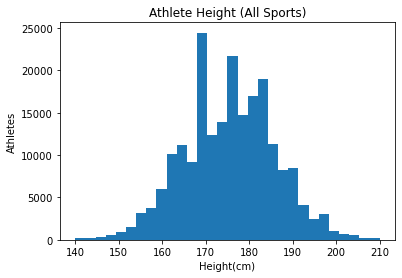

In [40]:
x = df['Height'].values
plt.figure(figsize = (6,4))
plt.hist(x, bins = 30, range = (140,210))
plt.xlabel('Height(cm)')
plt.ylabel('Athletes')
plt.title('Athlete Height (All Sports)')
plt.show()

The sports with the **tallest** average athletes are
* Basketball
* Volleyball
* Beach Volleyball
* Water Polo
* Rowing

In [41]:
df.groupby('Sport')['Height'].mean().dropna().sort_values(ascending = False).head()

Sport
Basketball          190.869879
Volleyball          186.994822
Beach Volleyball    186.144954
Water Polo          184.834648
Rowing              184.172222
Name: Height, dtype: float64

The sports with the **shortest** average athletes are 
* Gymnastics
* Trampolining
* Diving
* Weightlifting
* Rhymthmic Gymnastics

In [42]:
df.groupby('Sport')['Height'].mean().dropna().sort_values(ascending = False).tail()

Sport
Rhythmic Gymnastics    167.870253
Weightlifting          167.824801
Diving                 166.634264
Trampolining           166.582781
Gymnastics             162.936020
Name: Height, dtype: float64

Text(0.5, 1.0, 'Heights of Gymnastics vs Basketball Athletes')

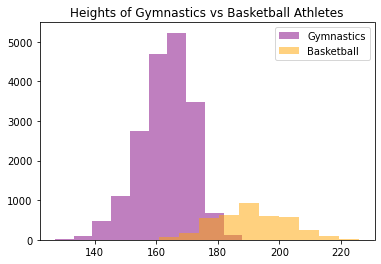

In [43]:
gymnastics_height = df[df['Sport'] == 'Gymnastics']['Height'].values
basketball_height = df[df['Sport'] == 'Basketball']['Height'].values

plt.hist(gymnastics_height, label = 'Gymnastics', color = 'purple', alpha = 0.5)
plt.hist(basketball_height, label = 'Basketball', color = 'orange', alpha = 0.5)
plt.legend()
plt.title('Heights of Gymnastics vs Basketball Athletes')

<a class="anchor" id="weight"></a>
### Weight

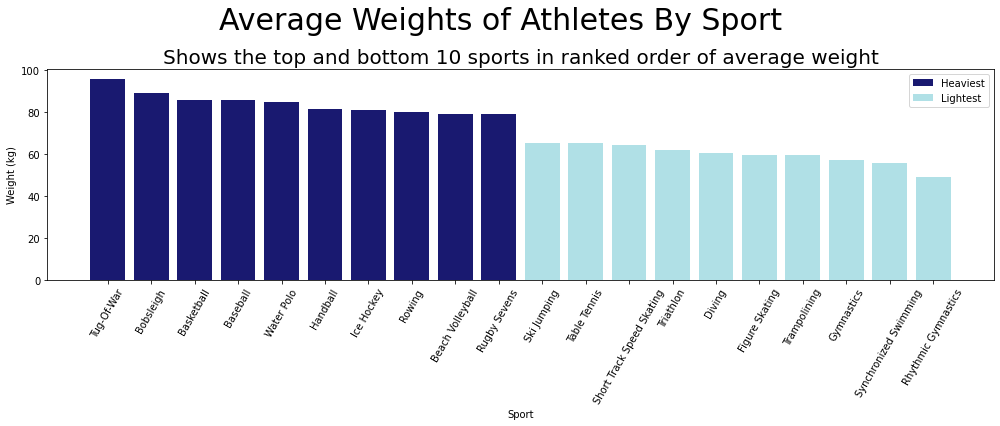

In [44]:

# Variables for bar plots
heaviest = df.groupby('Sport').mean()['Weight'].dropna().sort_values(ascending = False).head(10)
lightest = df.groupby('Sport').mean()['Weight'].dropna().sort_values(ascending = False).tail(10)

x_heavy = heaviest.index
x_light = lightest.index
y_heavy = heaviest.values
y_light = lightest.values


plt.figure(figsize = (14,6))
plt.bar(x_heavy, y_heavy, label = 'Heaviest', color = 'midnightblue')
plt.bar(x_light, y_light, label = 'Lightest', color = 'powderblue')
plt.suptitle('Average Weights of Athletes By Sport', fontsize = 30)
plt.title('Shows the top and bottom 10 sports in ranked order of average weight', fontsize = 20)
plt.xticks(rotation = 60, fontsize = 10)
plt.xlabel('Sport')
plt.ylabel('Weight (kg)')
plt.legend()
plt.tight_layout()
plt.show()

<a class="anchor" id="gender"></a>
### Gender

In [45]:
table = df.pivot_table(values = 'Athlete Name', index = ['Sex', 'Games'], aggfunc = 'count').reset_index()

women = table[table['Sex'] == 'F']
women[['Year', 'Season']] = women['Games'].str.split(' ', expand = True)
men = table[table['Sex'] == 'M']
men[['Year', 'Season']] = men['Games'].str.split(' ', expand = True)

women_summer = women[women['Season'] == 'Summer']
women_winter = women[women['Season'] == 'Winter']
men_summer = men[men['Season'] == 'Summer']
men_winter = men[men['Season'] == 'Winter']

C:\Users\tbert\AppData\Local\Temp\ipykernel_17628\3099484017.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  women[['Year', 'Season']] = women['Games'].str.split(' ', expand = True)
C:\Users\tbert\AppData\Local\Temp\ipykernel_17628\3099484017.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  women[['Year', 'Season']] = women['Games'].str.split(' ', expand = True)
C:\Users\tbert\AppData\Local\Temp\ipykernel_17628\3099484017.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

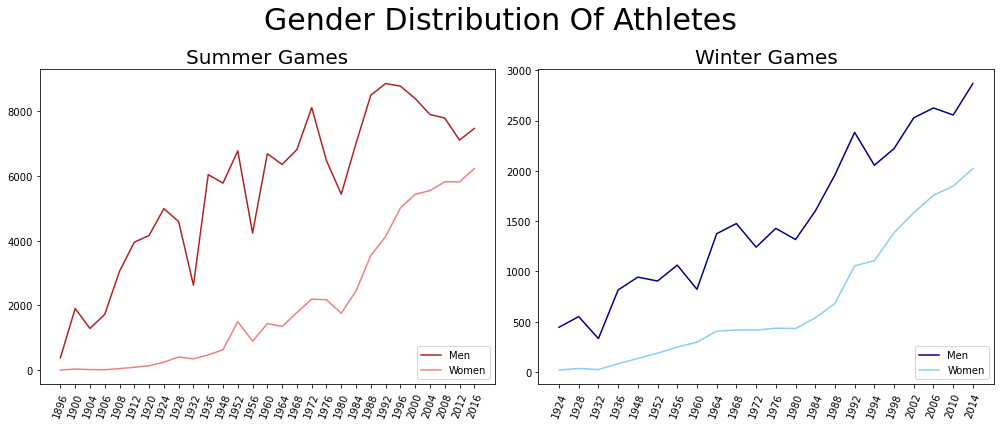

In [46]:
plt.figure(figsize = (14,6))
plt.suptitle('Gender Distribution Of Athletes', fontsize = 30)

plt.subplot(1,2,1)
plt.plot(men_summer['Year'].values, men_summer['Athlete Name'].values, color = 'firebrick', label = 'Men')
plt.plot(women_summer['Year'].values, women_summer['Athlete Name'].values, color = 'lightcoral', label = 'Women')
plt.legend(loc = 'lower right')
plt.xticks(rotation = 70)
plt.title('Summer Games', fontsize = 20)

plt.subplot(1,2,2)
plt.plot(men_winter['Year'].values, men_winter['Athlete Name'].values, color = 'darkblue', label = 'Men')
plt.plot(women_winter['Year'].values, women_winter['Athlete Name'].values, color = 'lightskyblue', label = 'Women')
plt.legend(loc = 'lower right')
plt.xticks(rotation = 70)
plt.title('Winter Games', fontsize = 20)

plt.tight_layout()
plt.show()